# Exercise 7

In this exercise, we will implement a recurrent network that operates on a sequence of input values and has to produce a single output value from that sequence.

In [1]:
import torch
import torch.nn as nn

## Dataset

The task of our network will be to count how long the input sequence is. For this, we generate a dataset with sequences of random length and with random values. We zero-pad the sequences to be the same length zeros, so that we can perform batching in the data loader. In order for the network to be able to distinguish the padding from the real sequence, we do not allow zeros to occur in the original sequence.

In [2]:
from torch.utils.data import Dataset, DataLoader
import random

class CpyDataset(Dataset):
    def __init__(self, num_samples, N, T):
        super(CpyDataset, self).__init__()

        def gen_seq():
            seq = [random.randint(0, 8) for _ in range(N)]
            return {
                "sequence": torch.as_tensor(seq + [0] * T + [9] * 3 + [0] * N),
                "label": torch.as_tensor(seq) # the label is just the length of the sequence
            }

        # generate a bunch of these sequences
        self.data = [gen_seq() for _ in range(num_samples)]

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return len(self.data)

## Dataloader

In [3]:
from torch.utils.data import DataLoader

N = 5
T = 0
seq_len = 2*N + T + 3

train_data = CpyDataset(20000, N, T)
val_data = CpyDataset(3000, N, T)

In [4]:
BATCH_SIZE = 128
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

## Network

Our network consists of just the RNN, followed by a linear layer to produce the final output.

In [14]:
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

class Regression_RNN(nn.Module):
    def __init__(self, input_size, output_size):
        super(Regression_RNN, self).__init__()
        self.hidden_size = 100
        self.rnn = nn.RNN(input_size, self.hidden_size, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, output_size)

    def forward(self, sequences):
        rnn_out, hidden = self.rnn(sequences)
        # Our RNN produces an output value for each input value in the sequence, but we use just the final value for our result
        res = self.linear(rnn_out[:, -1])
        return res


## Training

In [15]:
model = Regression_RNN(1, seq_len)
model.to(device)
LR = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=0.0001)

In [16]:
from torch.nn.functional import mse_loss
import numpy as np
import tqdm

NUM_EPOCHS = 10

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    # perform training followed by validation
    for mode, loader in [
        ("train", train_loader),
        ("val", val_loader)
    ]:
        # progressbar setup
        num_batches = len(loader)
        pbar = tqdm.tqdm(total=num_batches, desc=f"{mode} epoch {epoch}")

        if mode == "train":
            model.train() # do calculate gradients for training mode
        else:
            model.eval() # do not calculate gradients in validation mode

        # initial values of the metrics
        runningLoss = 0.
        correct_predictions = 0
        # total number of samples that were processed
        total_samples = 0
        
        # loop over the data
        for i_batch, batch in enumerate(loader):
            sequences, labels = batch['sequence'], batch['label']
            
            # move tensors to the correct device
            sequences = sequences.to(device)
            labels = labels.to(device)
            
            # convert everything to floats
            sequences = sequences.view(*sequences.shape, 1).to(torch.float)
            labels = labels.view(*labels.shape, 1).to(torch.float)
            
            # run the model
            predictions = model(sequences)
            predictions = torch.narrow(predictions, 1, seq_len-N, N).view(predictions.shape[0], N, 1)
            
            # loss calculation
            loss = mse_loss(predictions, labels)

            # calculate the metrics for the progress bar
            num_batch_samples = len(sequences)
            runningLoss += loss.item() * num_batch_samples
            total_samples += num_batch_samples
            
            pbar.update(1)
            pbar.set_postfix({
                "loss": runningLoss / total_samples
            })

            # weight update
            if mode == "train":
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
        epoch_loss = runningLoss / total_samples
        if mode == "train":
            train_losses.append(epoch_loss)
        else:
            val_losses.append(epoch_loss)

        pbar.close()

val epoch 9: 100%|██████████| 24/24 [00:00<00:00, 749.47it/s, loss=6.7] 


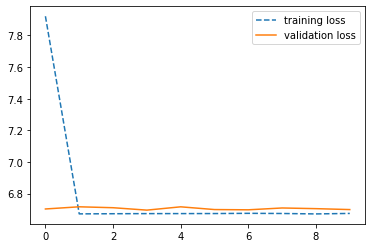

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_losses, '--', label="training loss")
plt.plot(val_losses, label="validation loss")
plt.legend()

plt.show()

In [19]:
model.eval()

for x in range(20):
    sequence, label = val_data[x]["sequence"], val_data[x]["label"]
    
    prediction = model(sequence.view(1, -1, 1).to(torch.float).to(device))
    
    pred_rounded = list(map(lambda x: round(x), prediction.view(-1).tolist()))
    
    print(f"{sequence.tolist()} -> {pred_rounded} [label: {label.tolist()}]")


[2, 3, 2, 4, 7, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [2, 3, 2, 4, 7]]
[6, 3, 6, 4, 0, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [6, 3, 6, 4, 0]]
[8, 0, 1, 8, 1, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [8, 0, 1, 8, 1]]
[4, 1, 4, 4, 1, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [4, 1, 4, 4, 1]]
[5, 4, 3, 5, 1, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [5, 4, 3, 5, 1]]
[3, 6, 6, 4, 1, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [3, 6, 6, 4, 1]]
[1, 8, 8, 3, 8, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [1, 8, 8, 3, 8]]
[3, 1, 7, 7, 6, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [3, 1, 7, 7, 6]]
[3, 8, 4, 3, 0, 9, 9, 9, 0, 0, 0, 0, 0] -> [0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4] [label: [3, 8, 4, 3, 0]]
[1, 8, 8, 4, 4, 9, 9, 9, 0, 

## Tasks for this notebook:

 - Instead of using nn.RNN, implement the RNN manually according to the lecture slides.
 
## Task: Memory copying
In a separate notebook, train an RNN for a different task: Memory copying. For this task, each input sequence consists of the following:
   - N random numbers from 0-8, followed by
   - T zeros, followed by
   - the value 9 three times, followed by
   - N zeros
   
The task of the network is then to generate a sequence of values, which are:
   - N+T+3 arbitrary values (not important), followed by
   - the same N random numbers from the start of the input sequence.
   
Some examples for $N=5, T=3$:

 - Input sequence: [9, 3, 7, 1, 2, 0, 0, 0, 9, 9, 9, 0, 0, 0, 0, 0]
 - Target sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 3, 7, 1, 2] (0 denotes arbitrary values)
 - Input sequence: [7, 1, 5, 7, 5, 0, 0, 0, 9, 9, 9, 0, 0, 0, 0, 0]:
 - Target sequence: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 1, 5, 7, 5] (0 denotes arbitrary values)
   
The task is thus to "remember" the numbers from the start of the sequence, and to produce them when the three nines have been encountered in the input sequence. With the parameter T, the delay until the numbers have to be produced can be amplified. Try out different values of T. For which values of T does the network still converge? Try exchanging nn.RNN for nn.LSTM and see if it can work with higher values of T. What is the reason that the network performance decreases for higher numbers of T?

Even for $T=0$ the model does not converge, the Loss decreases slightly but not sufficiently. Thus the results are wrong as well.